In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [74]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [75]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [76]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [77]:
X_train

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,Maruti Swift Dzire AMT VDI,2018,50000,Diesel,Individual,Automatic,First Owner
2290,Honda City 1.5 V AT,2008,70000,Petrol,Individual,Automatic,First Owner
874,Maruti Alto 800 LXI,2017,50000,Petrol,Individual,Manual,First Owner
1907,Datsun GO T Petrol,2015,92198,Petrol,Dealer,Manual,Second Owner
3244,Hyundai EON Era Plus,2013,3240,Petrol,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...
2895,Maruti Zen Estilo LXI BSIII,2008,40000,Petrol,Individual,Manual,First Owner
2763,Hyundai Grand i10 1.2 Kappa Asta,2019,15000,Petrol,Individual,Manual,First Owner
905,Maruti Ertiga VXI,2015,11918,Petrol,Trustmark Dealer,Manual,First Owner
3980,Hyundai Creta 1.6 CRDi SX Option,2015,90000,Diesel,Individual,Manual,Second Owner


__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [78]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [104]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric

    def fit(self, X, y):
        X_fit = X.copy()
        y_fit = y.copy()
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        self.dict_of_means = {col : ((X_with_target.groupby(col)["selling_price"].mean()) + np.random.standard_normal() * 0.006)
                              for col in self.categorical}
        
    def transform(self, df):
        self.df = df
        temp = self.df.copy()
        for col in self.categorical:
            temp[col] = temp[col].map(self.dict_of_means[col])

        temp = temp.fillna(0)
        return temp

In [105]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.478865,13.435892,50000,13.085954,12.611658,13.776443,12.959126
2290,12.125200,11.906484,70000,12.450179,12.611658,13.776443,12.959126
874,12.311508,13.333058,50000,12.450179,12.611658,12.643381,12.959126
1907,12.493842,13.053677,92198,12.450179,13.140882,12.643381,12.446379
3244,12.401697,12.857085,3240,12.450179,12.611658,12.643381,12.446379


In [106]:
X_test.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
2761,13.676757,13.549194,15000,13.085954,12.611658,12.643381,12.959126
3210,13.049908,12.925205,70000,13.085954,12.611658,12.643381,12.446379
2606,13.132308,12.623292,90000,13.085954,12.611658,12.643381,12.959126
1030,12.394349,13.131873,41000,12.450179,13.140882,12.643381,12.959126
3942,13.387774,12.925205,71318,13.085954,13.140882,12.643381,12.959126


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [107]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

{3: 0.7968292144892002, 5: 1.4418633938730097, 8: 1.988558286067395, 12: 1.9836351720543601}


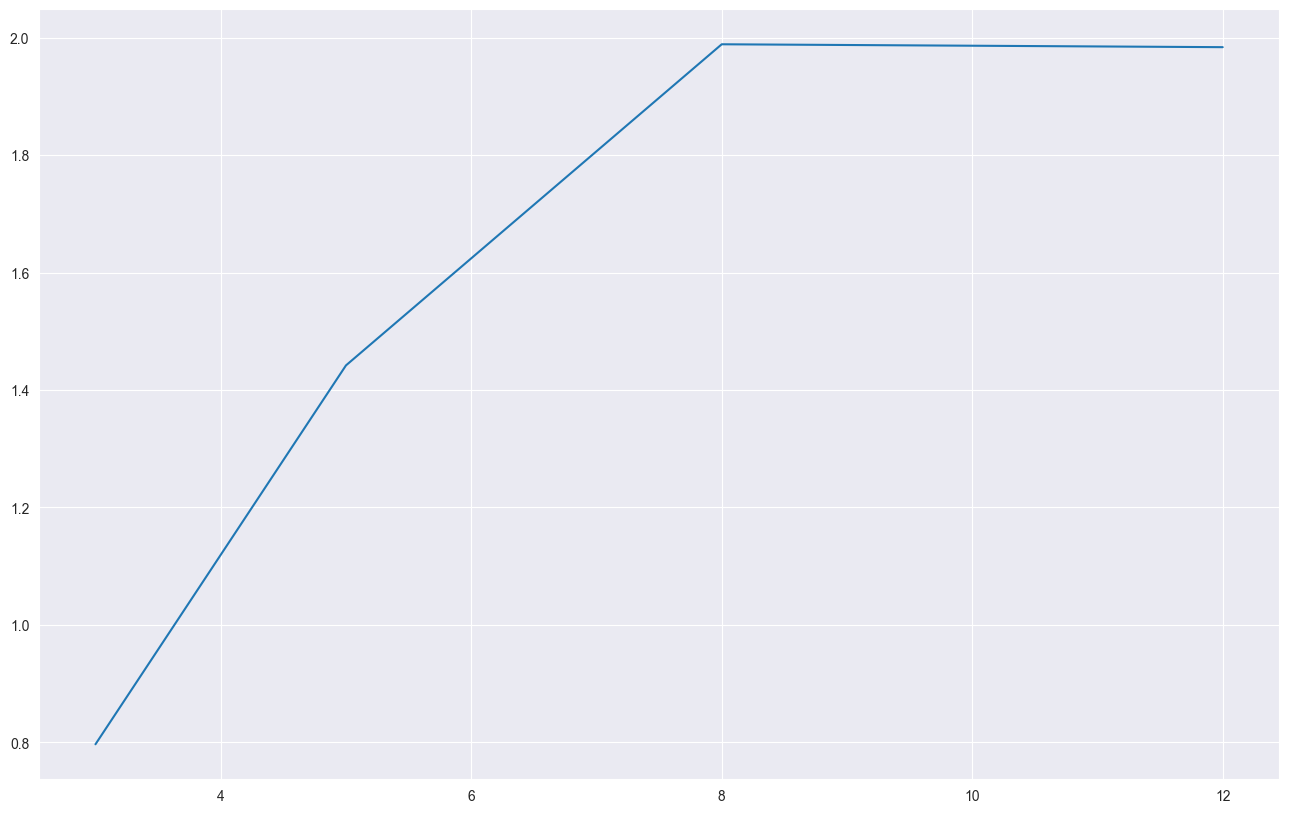

In [108]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import seaborn as sns
dict_error = {}
np.random.seed(1)
for depth in max_depth_list:
    pipe = Pipeline([("decision_tree", DecisionTreeRegressor(max_depth=depth))])
    pipe.fit(X_train, y_train)
    error = np.mean((pipe.predict(X_test) - y_test)**2)
    dict_error[depth] = error

print(dict_error)
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.lineplot(data=dict_error)
plt.show()




In [110]:
dict_error = {}

In [111]:
dict_error

{}

10
50
100
500
{10: 1.4309399590581773, 50: 1.4386960572382825, 100: 0.9520426718791575, 500: 0.807674795664653}


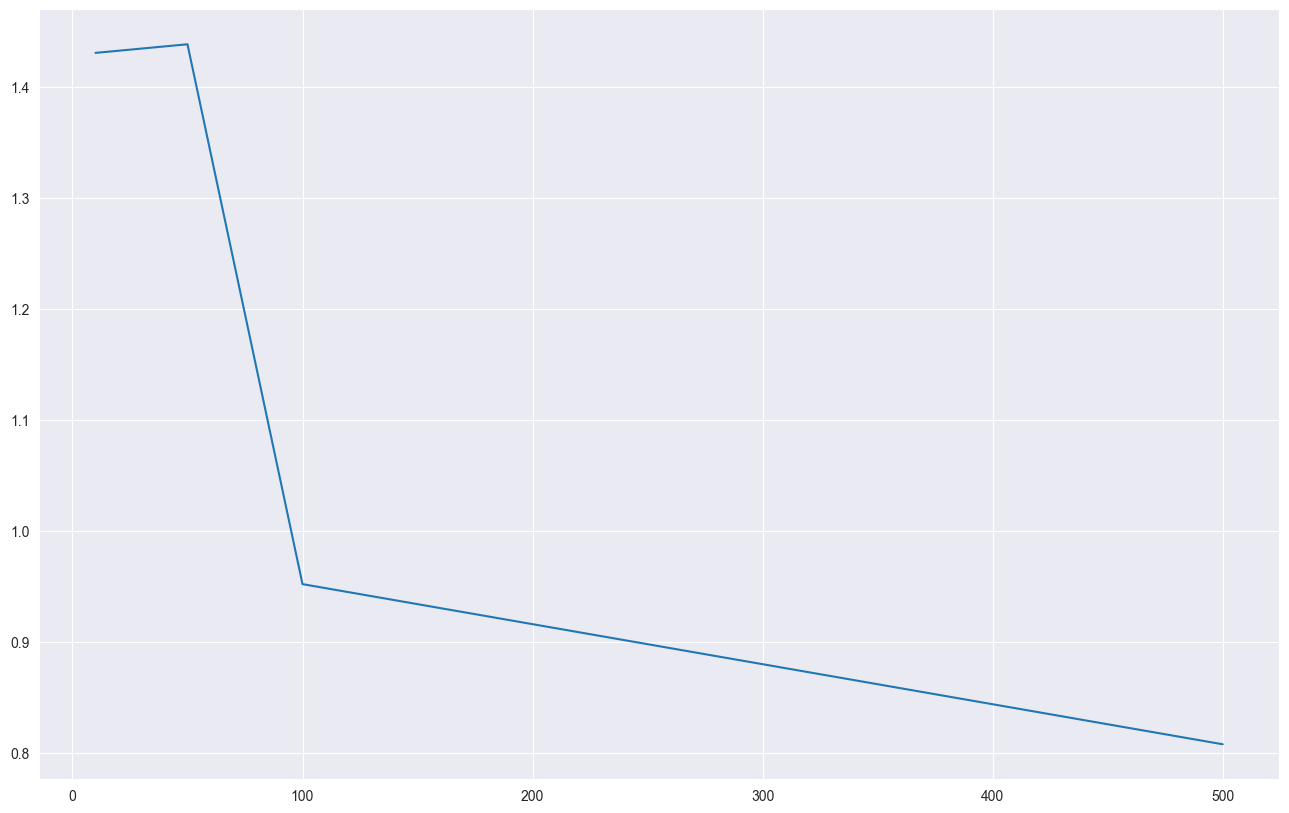

In [112]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import seaborn as sns
for split_list in min_samples_split_list:
    print(split_list)
    pipe = Pipeline([("decision_tree", DecisionTreeRegressor(min_samples_split=split_list))])
    pipe.fit(X_train, y_train)
    error = np.mean((pipe.predict(X_test) - y_test)**2)
    dict_error[split_list] = error

print(dict_error)
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.lineplot(data=dict_error)
plt.show()


{0: 1.9832848125401303, 0.1: 0.5204871413036622, 0.15: 0.5204871413036755, 0.2: 0.5204871413036218}


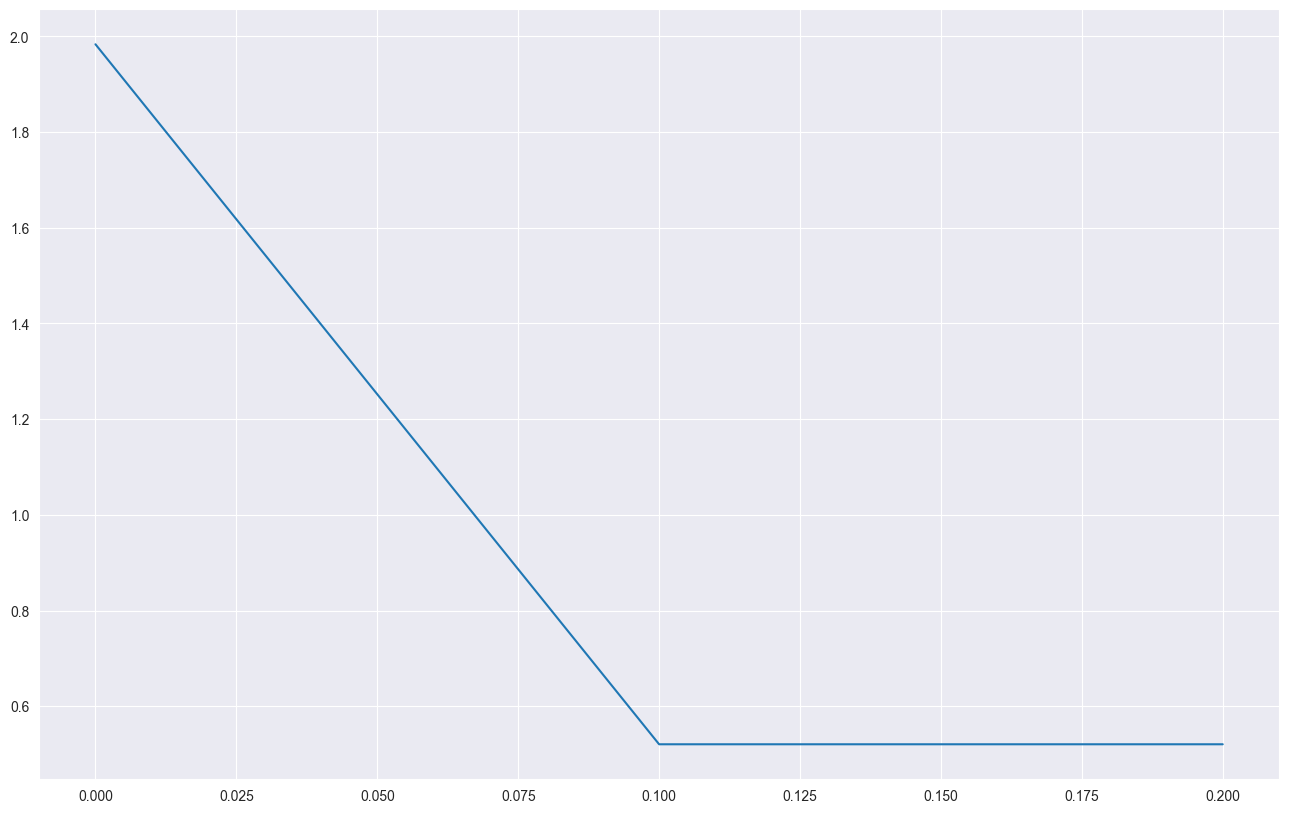

In [113]:
dict_error = {}
for impurity_decrease in min_impurity_decrease_list:
    pipe = Pipeline([("decision_tree", DecisionTreeRegressor(min_impurity_decrease=impurity_decrease))])
    pipe.fit(X_train, y_train)
    error = np.mean((pipe.predict(X_test) - y_test)**2)
    dict_error[impurity_decrease] = error

print(dict_error)
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.lineplot(data=dict_error)
plt.show()

In [3]:
np.random.seed(1)

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [116]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)


pipe = Pipeline([("decision_tree", DecisionTreeRegressor())])
search = GridSearchCV(pipe,
                      param_grid, cv=4, scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")






Best parameter (CV score=-0.04547):
{'decision_tree__max_depth': 8, 'decision_tree__max_leaf_nodes': 100, 'decision_tree__min_impurity_decrease': 0, 'decision_tree__min_samples_split': 50}
Качество лучшей модели на финальном тесте: -1.440644100450177
